# Суть задания


1.   Реализовать решение задачи верификации лица (сравнение 1 к 1)
2.   2 на кого из МИЭМ вы похожи + 2 GUI
2.   Протестировать работу различных методов трекинга объектов в различных задачах.

Примерное время выполнения - 8-10 часов.

Дедлайн: 1 февраля в 23:59

Штрафные коэффициенты оценивания при просрочке:

-|-
----|---
Просрочка меньше 12 часов | без штрафа
От 12 часов до 7 дней после дедлайна | 0.8
От 7 до 14 дней | 0.6
Более 14 дней и до начала сессии | 0.4

## Оценивание

Задание:

Часть работы | Стоимость в баллах
-------------|--------------------
Детекция + Верификация **Можно сдать без защиты**.| 3
Поисковик "MIEM Lookalikes" **Можно сдать без защиты**.| 2
MIEM Lookalike Web-GUI **Можно сдать без защиты**.| 1
Исследование устойчивости методов распознавания | 4
Итого | 10 баллов

Формула оценивания всей работы:

О = Задание * 0.9 + Тест на лекции * 0.1



# 2 MIEM Lookalike (2 балла)

Реализовать задачу поиска лиц с использованием эмбеддингов и FAISS

Задача:
Используйте предобученную модель распознавания лиц (например, FaceNet из библиотеки DeepFace) для создания эмбеддингов (векторных представлений) для всех изображений лиц из [выгрузки фотографий](https://drive.google.com/drive/folders/1I7EzyoJYYiLuOiPyjAHeSdTgzmDUAp2X?usp=sharing) сотрудников МИЭМ.
Создайте [FAISS](https://habr.com/ru/companies/okkamgroup/articles/509204/)-базу данных для хранения эмбеддингов лиц.
Реализуйте функцию поиска:
* Загрузите изображение нового лица.
* Извлеките эмбеддинг и найдите ближайший эмбеддинг в FAISS.
* Реализуйте выдачу имени человека с наиболее похожим лицом и его расстояние до текущего лица.

По-умолчанию предполагается выполнение решения в виде консольного скрипта или внутри блокнота Jupyter. Дополнительно можно реализовать веб-интерфейс с помощью библиотеки streamlit или другого веб-фреймворка на ваше усмотрение (+1 балл).


In [6]:
!pip install faiss-gpu-cu12

In [8]:
! pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.7 MB/s eta 0:00:00


In [10]:
! pip install deepface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.0 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=86058dd57c62e1fe879872bc01bd0053b31f54ec1cd098f6f06d305e0cd65061
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6c24b609dfb8a89
Successfully built fire


In [96]:
import cv2

import faiss
import numpy as np

# import streamlit as st
from deepface import DeepFace

from glob import glob
import os
from tqdm import tqdm

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [57]:
# Папка с изображениями сотрудников МИЭМ
DATASET_PATH = "drive/MyDrive/IMMM_25/hse_faces_miem/"
INDEX_FILE = "face_index.faiss"
EMBEDDINGS_FILE = "embeddings.npy"
NAMES_FILE = "names.npy"
glob(os.path.join(DATASET_PATH, "*.jpeg"))

['drive/MyDrive/IMMM_25/hse_faces_miem/117_miem.jpeg',
 'drive/MyDrive/IMMM_25/hse_faces_miem/116_miem.jpeg',
 'drive/MyDrive/IMMM_25/hse_faces_miem/115_miem.jpeg',
 'drive/MyDrive/IMMM_25/hse_faces_miem/111_miem.jpeg',
 'drive/MyDrive/IMMM_25/hse_faces_miem/110_miem.jpeg',
 'drive/MyDrive/IMMM_25/hse_faces_miem/112_miem.jpeg',
 'drive/MyDrive/IMMM_25/hse_faces_miem/113_miem.jpeg',
 'drive/MyDrive/IMMM_25/hse_faces_miem/109_miem.jpeg',
 'drive/MyDrive/IMMM_25/hse_faces_miem/10_miem.jpeg',
 'drive/MyDrive/IMMM_25/hse_faces_miem/114_miem.jpeg',
 'drive/MyDrive/IMMM_25/hse_faces_miem/103_miem.jpeg',
 'drive/MyDrive/IMMM_25/hse_faces_miem/108_miem.jpeg',
 'drive/MyDrive/IMMM_25/hse_faces_miem/107_miem.jpeg',
 'drive/MyDrive/IMMM_25/hse_faces_miem/101_miem.jpeg',
 'drive/MyDrive/IMMM_25/hse_faces_miem/100_miem.jpeg',
 'drive/MyDrive/IMMM_25/hse_faces_miem/104_miem.jpeg',
 'drive/MyDrive/IMMM_25/hse_faces_miem/102_miem.jpeg',
 'drive/MyDrive/IMMM_25/hse_faces_miem/107_zulip.jpeg',
 'drive/My

In [66]:
def create_embedding_database():
    images = glob(os.path.join(DATASET_PATH, "*.jpeg"))
    embeddings = []
    names = []

    for img_path in tqdm(images, total = len(images)):
        try:
            embedding = DeepFace.represent(img_path, model_name="Facenet", enforce_detection=False)[0]["embedding"]
            embeddings.append(embedding)



            names.append(os.path.basename(img_path))
        except Exception as e:
            print(f"Ошибка обработки {img_path}: {e}")

    embeddings = np.array(embeddings, dtype=np.float32)
    faiss_index = faiss.IndexFlatL2(embeddings.shape[1])
    faiss_index.add(embeddings)

    faiss.write_index(faiss_index, INDEX_FILE)
    np.save(EMBEDDINGS_FILE, embeddings)
    np.save(NAMES_FILE, names)
    print("База данных эмбеддингов создана.")


In [71]:
if not os.path.exists(INDEX_FILE):
    print("База данных отсутствует. Создаём заново...")
    create_embedding_database()

База данных отсутствует. Создаём заново...


 69%|██████▉   | 326/474 [02:40<01:30,  1.64it/s]

Ошибка обработки drive/MyDrive/IMMM_25/hse_faces_miem/389_miem.jpeg: Exception while loading drive/MyDrive/IMMM_25/hse_faces_miem/389_miem.jpeg


100%|██████████| 474/474 [03:54<00:00,  2.02it/s]

База данных эмбеддингов создана.


In [72]:
def find_my_clone(image_path):
    try:
        embed = DeepFace.represent(image_path, model_name="Facenet", enforce_detection=False)[0]["embedding"]
        embed = np.array(embed, dtype=np.float32).reshape(1, -1)

        faiss_index = faiss.read_index(INDEX_FILE)
        pic_names = np.load(NAMES_FILE, allow_pickle=True)

        dist, idx = faiss_index.search(embed, 1)
        return pic_names[idx[0][0]], dist[0][0]
    
    except Exception as e:
        return None, None

Похожий сотрудник: Михайлова Светлана Олеговна, расстояние: 139.41


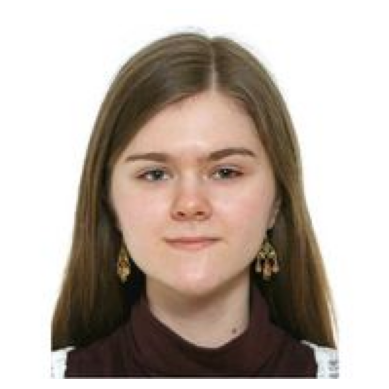

In [97]:
image_path = 'me.jpg'

if os.path.exists(image_path):

    name, distance = find_my_clone(image_path)

    if name:
        df = pd.read_csv(DATASET_PATH + '/staff_photo.csv')
        fio = df[df.filename == name].name
        print(f"Похожий сотрудник: {fio.values[0]}, расстояние: {distance:.2f}")

        img = mpimg.imread(DATASET_PATH + name)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        
    else:
        print("Не удалось найти похожее лицо.")
else:
    print("Файл не найден. Проверьте путь.")